In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from itertools import cycle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns # easy visualization


In [524]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_whole = pd.concat([df_train, df_test], axis = 0, ignore_index=True)

# save the test PassengerID for future use
ids = df_test['PassengerId']
print(df_whole.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## EDA & Insights

In [525]:
print(df_whole.describe())
print(df_whole.info())
np.sum(df_whole.isna())

       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max       9.000000   512.329200  
<class 'pandas.core.frame.DataFrame'

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Seems to have a lot of empty values in Cabin and Age. A few missing values in Fare and Embarked. We must deal with these empty values in order to have a complete model. 

<AxesSubplot:xlabel='Survived', ylabel='count'>

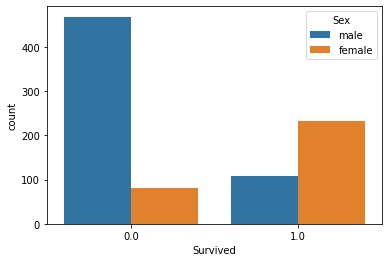

In [526]:
sns.countplot(x='Survived', hue='Sex', data=df_whole)


More men died than women, and there were significantly less survivors than those who survived

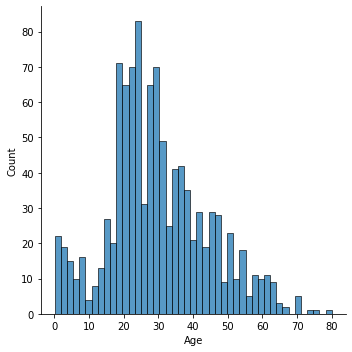

In [527]:
sns.displot(df_whole['Age'].dropna(), kde=False, bins = 45)

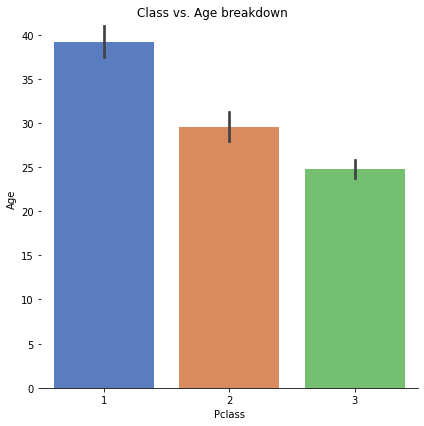

In [528]:
# Draw a nested barplot to show Age breakdown for differetn classes
# https://stackoverflow.com/questions/60237979/python-and-seaborn-how-to-plot-
# two-categorical-features-using-barplot
g = sns.catplot(x="Pclass", y="Age", hue=None, data = df_whole,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.fig.suptitle("Class vs. Age breakdown")
g.set_ylabels("Age")

Seems like a lot of 20s and 30s year old were on the boat. Additionally, there were more young children compared to old folk

## Data Cleaning and Adhering to Assumptions

In [529]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Going to deal with Age first, trying to modify it to replace the missing values with age. Chose to split it by class becuase assuming that each age group aligns with different classes. 

In [530]:
print(df_whole.groupby('Pclass').mean()['Age'])

# replacing each class's empty age values with the respective means
def fill_age(cols):
    Age = cols['Age']
    Pclass = cols['Pclass']  
    if pd.isnull(Age):
        if Pclass == 1:
            return 39
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64


In [531]:
df_tests = df_whole.copy()
df_whole['Age'] = df_whole[['Age', 'Pclass']].apply(fill_age, axis = 1)

# age handled, Fare and Embarked has missing data, Cabin is 
# missing a lot of 
#data so we drop it as well as Ticket as ticket correlates 
# with other possible
# features
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [532]:
df_whole.drop(['Cabin', 'Ticket'], axis=1, inplace=True)
df_whole.groupby('Pclass').mean()['Fare']

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [533]:
print(df_whole[df_whole['Fare'].isnull()])
print(df_whole[df_whole['Embarked'].isnull()])

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch  Fare Embarked  
1043      0   NaN        S  
     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Fare Embarked  
61   female  38.0      0      0  80.0      NaN  
829  female  62.0      0      0  80.0      NaN  


In [534]:
# replacing null fare for passenger with the average fare 
# for respective class
df_whole.loc[df_whole['PassengerId'] == 1044, 'Fare'] = 13.302889

# replacing null embarked status with 'C' for two passengers
df_whole.loc[df_whole['PassengerId'].isin([62, 830]), 'Embarked'] = 'C'
df_whole.loc[df_whole['PassengerId'].isin([62, 830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,C
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,C


In [535]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Fare         1309 non-null   float64
 9   Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


In [536]:
gender = pd.get_dummies(df_whole['Sex'], drop_first=True)
print(gender.head())
embarked = pd.get_dummies(df_whole['Embarked'], drop_first=True)
print(embarked.head())

df_whole = pd.concat([df_whole, gender, embarked], axis = 1)
df_whole.drop(['Sex', 'Embarked'], axis = 1, inplace=True)
df_whole.head()

   male
0     1
1     0
2     0
3     0
4     1
   Q  S
0  0  1
1  0  0
2  0  1
3  0  1
4  0  1


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Q,S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1


In [537]:
# dropping unneccessary identifiers 
df_whole.drop(['Name', 'PassengerId'], axis=1, inplace=True)
df_whole

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,25.0,0,0,8.0500,1,0,1
1305,NaN,1,39.0,0,0,108.9000,0,0,0
1306,NaN,3,38.5,0,0,7.2500,1,0,1
1307,NaN,3,25.0,0,0,8.0500,1,0,1


In [538]:
# splitting data

df_train_alt = df_whole[:891]
df_test_alt = df_whole[891:]

X = df_train_alt.drop('Survived', axis=1)
y = df_train_alt['Survived']

df_whole.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1


In [539]:
def showPrecisionRecallScores(pipe):
    predictions = cross_val_predict(pipe, X, y, cv = 3)
    print("Precision: ", precision_score(y, predictions))
    print("Recall: ",recall_score(y, predictions))

## Random Forest Regressor

In [540]:
# https://scikit-learn.org/stable/modules/generated/sklearn.
#ensemble.RandomForestRegressor.html

X_test = df_test_alt.drop('Survived', axis=1)

pipe_forest_forest_reg = make_pipeline(StandardScaler(), 
                                       RandomForestRegressor())
pipe_forest_forest_reg.fit(X, y)  # apply scaling on training data
predictions_forest_forest_reg = pipe_forest_forest_reg.predict(X_test)

acc_forest_reg = round(pipe_forest_forest_reg.score(X,y) * 100, 2)
acc_forest_reg

88.56

Accuraccy of 88.6% for random forest regressor, lets see if we can improve that score with the hyperparameters.

Making a default random forest regressor model that is not hyperparameterized. I will compare both of the kaggle scores and other metrics between the default and hyper parameterized version of the models

In [541]:
df_predictions_forest_reg = pd.DataFrame({'PassengerID' : ids, 
                        'Survived' : predictions_forest_reg.astype(int)})
df_predictions_forest_reg.to_csv('forest_reg_submission.csv', index=False)

Using the keys to help understand what parameters are possibly relevent for and modify that

In [542]:
print(sorted(pipe_forest_forest_reg.get_params().keys()))

['memory', 'randomforestregressor', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start', 'standardscaler', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'steps', 'verbose']


In [543]:
# https://stackoverflow.com/questions/43366561/
#use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once
MSE = make_scorer(mean_squared_error, greater_is_better=False)
X_test = df_test_alt.drop('Survived', axis=1)

# basing the hyperparameters from the textbook and the preliminary EDA
param_grid = {
    'randomforestregressor__n_estimators': [100,200,500,1000],
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [50, 75, 100],
    'randomforestregressor__max_features': ['auto'],
    }

pipe_forest_forest_reg_2 = make_pipeline(StandardScaler(), 
                                         RandomForestRegressor())

grid_search = GridSearchCV(pipe_forest_forest_reg_2, param_grid, n_jobs=-1, 
                           cv=4, scoring=MSE, verbose=2)
grid_search.fit(X, y)
predictions_grid_predict_extra_tree = grid_search.predict(X_test)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


In [544]:
print('Random forest regression: ')
print('Best Params:', grid_search.best_params_)
print('Best CV Score:', -grid_search.best_score_)

Random forest regression: 
Best Params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 500}
Best CV Score: 0.14151214091440775


In [545]:
df_predictions_grid_predict_extra_tree = pd.DataFrame({'PassengerID' : ids, 
    'Survived' : predictions_grid_predict_extra_tree.astype(int)})
df_predictions_grid_predict_extra_tree.to_csv\
('forest_reg_grid_submission.csv', index=False)

## Gradient Boosted Trees

In [548]:
X_test = df_test_alt.drop('Survived', axis=1)
pipe_gbrt = make_pipeline(StandardScaler(), GradientBoostingClassifier())
pipe_gbrt.fit(X, y)  # apply scaling on training data
predictions_gbrt = pipe_gbrt.predict(X_test)


In [549]:
df_predictions_gbrt = pd.DataFrame({'PassengerID' : ids, 
                        'Survived' : predictions_gbrt.astype(int)})
df_predictions_gbrt.to_csv('gbrt_submission.csv', index=False)

In [553]:
# https://datascience.stackexchange.com/questions/29410/
# how-to-set-parameters-to-search-in-scikit-learn-gridsearchcv

print(sorted(pipe_gbrt.get_params().keys()))


['gradientboostingclassifier', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 'gradientboostingclassifier__validation_fraction', 'gradientboostingclassifier__verbose', 'gradientboostingclassifier__warm_start', 'memory', 'standardscaler', 'standardscaler__copy', 'standardscaler__with_mean', 'standar

In [554]:
MSE = make_scorer(mean_squared_error, greater_is_better=False)
X_test = df_test_alt.drop('Survived', axis=1)

param_grid = {
    'gradientboostingclassifier__criterion' : ['gini'],
    'gradientboostingclassifier__n_estimators': [100,200,500,1000],
    'gradientboostingclassifier__max_depth': [25, 50, 75, 100],
    'gradientboostingclassifier__max_features': ['auto'],
    }

pipe_forest_gbrt_2 = make_pipeline(StandardScaler(), 
                                   GradientBoostingClassifier())

grid_search = GridSearchCV(pipe_forest_gbrt_2, param_grid, n_jobs=-1,cv=4,
                           scoring=MSE, verbose=2)
grid_search.fit(X, y)
predictions_grid_predict_gbrt = grid_search.predict(X_test)


print('Gradient boosted trees classifier...')
print('Best Params:', grid_search.best_params_)
print('Best CV Score:', -grid_search.best_score_)

df_predictions_grid_predict_gbrt = pd.DataFrame({'PassengerID' : ids, 
     'Survived' : predictions_grid_predict_gbrt.astype(int)})
df_predictions_grid_predict_gbrt.to_csv('gbrt_grid_submission.csv', 
                                        index=False)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Gradient boosted trees classifier...
Best Params: {'gradientboostingclassifier__max_depth': 100, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__n_estimators': 1000}
Best CV Score: 0.20201086736961177


The CV score is quite high, I expect this model to perform the best in comparison to the others

## Extra Trees

In [555]:
X_test = df_test_alt.drop('Survived', axis=1)


pipe_forest_extra_trees = make_pipeline(StandardScaler(), 
                                        ExtraTreesRegressor())
pipe_forest_extra_trees.fit(X, y)  # apply scaling on training data
predictions_forest_extra_trees = pipe_forest_extra_trees.predict(X_test)

In [556]:

print(sorted(pipe_forest_extra_trees.get_params().keys()))


['extratreesregressor', 'extratreesregressor__bootstrap', 'extratreesregressor__ccp_alpha', 'extratreesregressor__criterion', 'extratreesregressor__max_depth', 'extratreesregressor__max_features', 'extratreesregressor__max_leaf_nodes', 'extratreesregressor__max_samples', 'extratreesregressor__min_impurity_decrease', 'extratreesregressor__min_samples_leaf', 'extratreesregressor__min_samples_split', 'extratreesregressor__min_weight_fraction_leaf', 'extratreesregressor__n_estimators', 'extratreesregressor__n_jobs', 'extratreesregressor__oob_score', 'extratreesregressor__random_state', 'extratreesregressor__verbose', 'extratreesregressor__warm_start', 'memory', 'standardscaler', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'steps', 'verbose']


In [557]:
MSE = make_scorer(mean_squared_error, greater_is_better=False)
X_test = df_test_alt.drop('Survived', axis=1)

param_grid = {
    'extratreesregressor__n_estimators': [100,200,500,1000],
'extratreesregressor__bootstrap': [True],
    'extratreesregressor__max_depth': [50, 75, 100],
    'extratreesregressor__max_features': ['auto'],
    }

pipe_forest_extra_trees_2 = make_pipeline(StandardScaler(),
                                          ExtraTreesRegressor())

grid_search = GridSearchCV(pipe_forest_extra_trees_2, param_grid, 
                           n_jobs=-1, cv=4, scoring=MSE, verbose=2)
grid_search.fit(X, y)
predictions_grid_predict_extra_tree = grid_search.predict(X_test)


print('Extra trees regression...')
print('Best Params:', grid_search.best_params_)
print('Best CV Score:', -grid_search.best_score_)

df_predictions_grid_predict_extra_tree = pd.DataFrame({'PassengerID' : ids, 
            'Survived' : predictions_grid_predict_extra_tree.astype(int)})
df_predictions_grid_predict_extra_tree.to_csv\
('extra_trees_grid_submission.csv', index=False)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Extra trees regression...
Best Params: {'extratreesregressor__bootstrap': True, 'extratreesregressor__max_depth': 50, 'extratreesregressor__max_features': 'auto', 'extratreesregressor__n_estimators': 500}
Best CV Score: 0.14477897060618317


I wanted to use the same paramaters for the hypertuning to see which one would perform better in comparison to Random forest regressor, as both models are very similar according to the textbook. It seems like not a huge difference is between the Extra Trees and Random Forest, so the kaggle hidden test case will show us. The CV score is slightly better on Extree Trees, thus I predict it to be slightly better on the hidden test cases. 

In [558]:
df_predictions_extra_trees = pd.DataFrame({'PassengerID' : ids, 
                'Survived' : predictions_forest_extra_trees.astype(int)})
df_predictions_extra_trees.to_csv('extra_trees_submission.csv', index=False)

[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=100; total time=   1.7s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=200; total time=   3.4s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=500; total time=   7.0s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=1000; total time=  12.1s
[CV] END gradientboostingclassifier__max_depth=50, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=200; total time=   3.6s
[CV] END gradientboostingclassifier__max_depth=50, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=500; total time=   7.0s
[CV] END gradientboos

[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=100; total time=   1.7s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=200; total time=   3.4s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=500; total time=   6.9s
[CV] END gradientboostingclassifier__max_depth=25, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=1000; total time=  11.7s
[CV] END gradientboostingclassifier__max_depth=50, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=100; total time=   1.7s
[CV] END gradientboostingclassifier__max_depth=50, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=200; total time=   4.2s
[CV] END gradientboos